# Diagnostics_vec

A diagnostics package for output only where you want it.

## Motivation
Boundary conditions are a critical part of generating regional ocean model domains. Using state estimates like ECCO, data-informed boundary conditions can be generated to provide data-aware regional domains. However, boundary conditions are often needed at high frequency for a number of applications, and this high frequency output is very expensive at global scales. Thus, the `diagnostics_vec` package was generated to output model variables in localized areas, but only in certain areas of the domain in order to preserve I/O time and disk space.

While this package was generated with boundary conditions in mind, it does not necessarily need to be used that way. The user can provide any mask they like to request output anywhere in the domain - from single points ("virtual moorings") to small subsets of the domain.

Let's take a look at an example

**Import the modules for this notebook**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt


## Preparing the demo

This demo will utilize the `tutorial_global_oce_latlon` experiment provided with MITgcm.

Let's start with a fresh clone of MITgcm and the `diagnostics_vec` package.

```
git clone https://github.com/MITgcm/MITgcm.git
git clone https://github.com/mhwood/diagnostics_vec.git
```

Next, use some of the provided python utilities to add `diagnostics_vec` to the model source code.

```
cd diagnostics_vec/utils/
python3 copy_pkg_files_to_MITgcm.py -m ../../MITgcm
```

Subsequently, let's navigate to the tutorial experiment that will be used for this demo.

```
cd ../../MITgcm/verification//tutorial_global_oce_latlon/
```

## Compiling the Model

To compile with `DIAGNOSTICS_VEC`, we will want to update to key files in our code mods directory.

First up, let's modify the `DIAGNOSTICS_VEC_SIZE.h` file:
```
cd code/
cp ../../../pkg/diagnostics_vec/DIAGNOSTICS_VEC_SIZE.h .
vim DIAGNOSTICS_VEC_SIZE.h
```

Edit this file with the following lines:

```
INTEGER, PARAMETER :: VEC_points = 1800
INTEGER, PARAMETER :: nVEC_mask = 4
INTEGER, PARAMETER :: nSURF_mask = 0
```

Next, let's add `diagnostics_vec` to the list of packages for this model:

```
vim packages.conf
# add a line for diagnostics_vec
```

Finally, let's change the model to run with MPI:

```
vim ../code/SIZE.h
```

And update with the following:

```
     &           sNx =  45,
     &           sNy =  40,
     &           OLx =   2,
     &           OLy =   2,
     &           nSx =   1,  <- change to this
     &           nSy =   1,
     &           nPx =   2,  <- change to this
     &           nPy =   1,
     &           Nx  = sNx*nSx*nPx,
     &           Ny  = sNy*nSy*nPy,
     &           Nr  =  15)
```


Next, let's build the model by loading in some modules

```
module purge
source /shared/spack/share/spack/setup-env.sh
module add openmpi-4.1.1-gcc-9.4.0-jgsdvep
module add netcdf-fortran-4.5.3-gcc-11.1.0-d35hzyr
```

and the running the typical compile commands:

```
cd ../build
export MPI_HOME=/efs_ecco/ECCO/EMU2/emu_dir/ompi
../../../tools/genmake2 -of ../../../tools/build_options/darwin_amd64_gfortran -mods ../code -mpi
make depend
make
```

## Preparing the diagnostic_vec fields

To run with `diagnostics_vec`, we will need some masks for each of the outputs we would like. Let's suppose we would like to make a regional domain in the North Pacific created with boundary conditions from our global model. Let's plot this domain on the bathymetry of the model to see where our regional model will be located.

Begin by modifying the model path and reading in the bathymetry:

In [2]:
model_path = '/efs_ecco/mwood/dv_example/MITgcm/verification/tutorial_global_oce_latlon'

In [3]:
# read in the bathymetry
n_rows = 40
n_cols = 90
bathy = np.fromfile(os.path.join(model_path,'input','bathymetry.bin'),'>f4').reshape((n_rows,n_cols))

FileNotFoundError: [Errno 2] No such file or directory: '/efs_ecco/mwood/dv_example/MITgcm/verification/tutorial_global_oce_latlon/input/bathymetry.bin'

Next, let's define our subdomain and plot it on the map:

In [39]:
#define the rows/cols of the subdomain
sub_row_min=20
sub_row_max=30
sub_col_min=45
sub_col_max=55

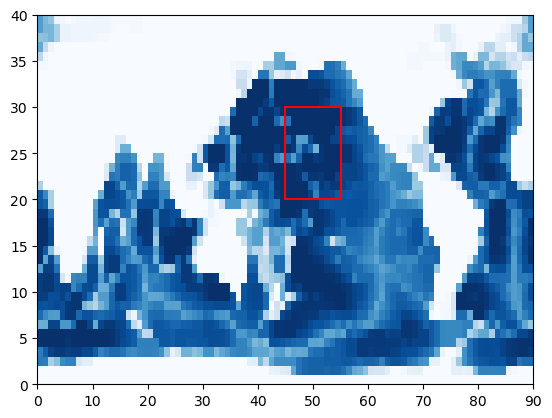

In [40]:
# make a plot
fig = plt.figure()
plt.pcolormesh(bathy,cmap='Blues_r')
plt.plot([sub_col_min, sub_col_max], [sub_row_min, sub_row_min], 'r-')
plt.plot([sub_col_max, sub_col_max], [sub_row_min, sub_row_max], 'r-')
plt.plot([sub_col_min, sub_col_min], [sub_row_min, sub_row_max], 'r-')
plt.plot([sub_col_min, sub_col_max], [sub_row_max, sub_row_max], 'r-')
plt.show()

Given this domain, we can make masks for `diagnostics_vec` that can be used to generate outputs from the global model along our boundary. In turn, these outputs could be used to generate the subdomain boundary conditions (perhaps via interpolation). 

To generate the masks, we make an array which is zero everywhere except for the boundary location, where we count our points sequentially:

In [45]:
# make the north mask
north_mask = np.zeros((n_rows, n_cols))
counter = 1
for col in range(sub_col_min, sub_col_max+1):
    north_mask[sub_row_max,col] = counter
    counter +=1
print('The north mask has '+str(np.sum(north_mask!=0))+' points')

# make the south mask
south_mask = np.zeros((n_rows, n_cols))
counter = 1
for col in range(sub_col_min, sub_col_max+1):
    south_mask[sub_row_min,col] = counter
    counter +=1
print('The south mask has '+str(np.sum(south_mask!=0))+' points')

# make the east mask
east_mask = np.zeros((n_rows, n_cols))
counter = 1
for row in range(sub_row_min, sub_row_max+1):
    east_mask[row,sub_col_min] = counter
    counter +=1
print('The east mask has '+str(np.sum(east_mask!=0))+' points')

# make the west mask
west_mask = np.zeros((n_rows, n_cols))
counter = 1
for row in range(sub_row_min, sub_row_max+1):
    west_mask[row,sub_col_max] = counter
    counter +=1 
print('The west mask has '+str(np.sum(west_mask!=0))+' points')

The north mask has 11 points
The south mask has 11 points
The east mask has 11 points
The west mask has 11 points


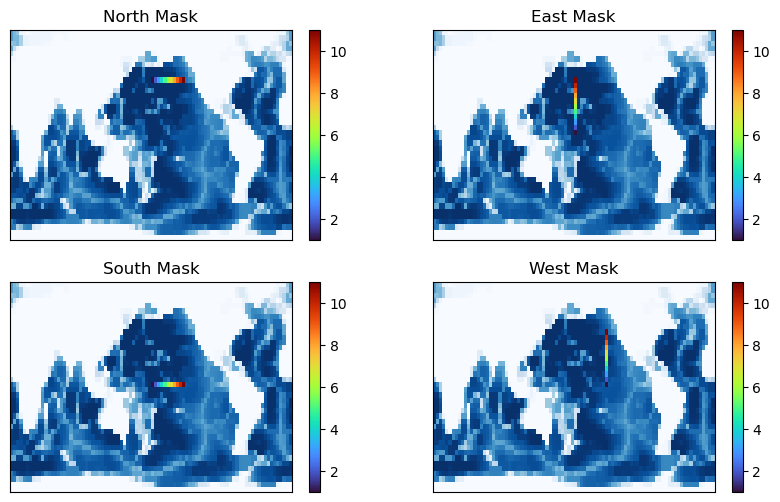

In [42]:
# make a figure
fig = plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.pcolormesh(bathy,cmap='Blues_r')
plot_mask = np.ma.masked_where(north_mask==0, north_mask)
C = plt.pcolormesh(plot_mask,cmap='turbo',label='Mask Count')
plt.colorbar(C)
plt.title('North Mask')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.subplot(2,2,2)
plt.pcolormesh(bathy,cmap='Blues_r')
plot_mask = np.ma.masked_where(east_mask==0, east_mask)
C = plt.pcolormesh(plot_mask,cmap='turbo',label='Mask Count')
plt.colorbar(C)
plt.title('East Mask')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.subplot(2,2,3)
plt.pcolormesh(bathy,cmap='Blues_r')
plot_mask = np.ma.masked_where(south_mask==0, south_mask)
C = plt.pcolormesh(plot_mask,cmap='turbo',label='Mask Count')
plt.colorbar(C)
plt.title('South Mask')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.subplot(2,2,4)
plt.pcolormesh(bathy,cmap='Blues_r')
plot_mask = np.ma.masked_where(west_mask==0, west_mask)
C = plt.pcolormesh(plot_mask,cmap='turbo',label='Mask Count')
plt.colorbar(C)
plt.title('West Mask')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.show()

After you're happy with your masks, you can output them to your run directory

In [43]:
# make a place for the dv output to be placed
if 'dv' not in os.listdir(os.path.join(model_path,'run')):
    os.mkdir(os.path.join(model_path,'run','dv'))

# output the masks to your run directory
north_mask.ravel('C').astype('>f4').tofile(os.path.join(model_path,'run','dv','north_mask.bin'))
south_mask.ravel('C').astype('>f4').tofile(os.path.join(model_path,'run','dv','south_mask.bin'))
west_mask.ravel('C').astype('>f4').tofile(os.path.join(model_path,'run','dv','west_mask.bin'))
east_mask.ravel('C').astype('>f4').tofile(os.path.join(model_path,'run','dv','east_mask.bin'))

The final file we will need is a `data.diagnostics` file. Here is an example:

```
 &DIAG_VEC_INPUT_VARS
#
 nml_startTime = 0,
 nml_endTime = 3153600000.,
#
# identify the masks
#
 nml_vecFiles(1) = 'dv/north_mask.bin',
 nml_vecFiles(2) = 'dv/south_mask.bin',
 nml_vecFiles(3) = 'dv/east_mask.bin',
 nml_vecFiles(4) = 'dv/west_mask.bin',
#
# determine how many model iterations will be stored in each file
#
 nml_vec_iters_per_file(1:4) = 365, 365, 365, 365
#
# determine the output/averaging period
#
 nml_vec_avg_periods(1:4) = 86400., 86400., 86400., 86400.,
#
 nml_fields2D(1:1,1) = 'ETAN    ',
 nml_fields2D(1:1,2) = 'ETAN    ',
 nml_fields2D(1:1,3) = 'ETAN    ',
 nml_fields2D(1:1,4) = 'ETAN    ',
#
 nml_fields3D(1:4,1) = 'THETA   ','SALT   ','VVEL   ','UVEL    ',
 nml_levels3D(1:4,1) =   15, 15, 15, 15,
 nml_fields3D(1:4,2) = 'THETA   ','SALT   ','VVEL   ','UVEL    ',
 nml_levels3D(1:4,2) =   15, 15, 15, 15,
 nml_fields3D(1:4,3) = 'THETA   ','SALT   ','VVEL   ','UVEL    ',
 nml_levels3D(1:4,3) =   15, 15, 15, 15,
 nml_fields3D(1:4,4) = 'THETA   ','SALT   ','VVEL   ','UVEL    ',
 nml_levels3D(1:4,4) =   15, 15, 15, 15,
#
 nml_filePrec = 32,
 &
```

Generate a file in your run directory called `data.diagnostics` with the output described above.

## Running the model
To run the model, first we will prepare the run directory:

```
cd run
ln -s ../build/mitgcmuv .
ln -s ../input/* .
```

Before running, we will edit 2 files. First let's edit the `data.pkg` file to include a line for `diagnostics_vec`:

`
 useDiagnostics_vec = .TRUE.,
`

Next, let's edit the `data` file to run for one year by changing `nTimeSteps` to 365. You may also like to change the `dumpFreq` to 31536000 since we don't care about the typical output for this example.

To run the model, we can use a job script, e.g. `dv_test.slm` as follows:

```
#!/bin/bash
#SBATCH --ntasks=2
#SBATCH --ntasks-per-node=2
#SBATCH --exclusive
#SBATCH --partition=sealevel-c5xl-demand
#SBATCH --mem-per-cpu=1GB
#SBATCH --time=1:00:00

module purge
source /shared/spack/share/spack/setup-env.sh
module add openmpi-4.1.1-gcc-9.4.0-jgsdvep
module add netcdf-fortran-4.5.3-gcc-11.1.0-d35hzyr

mpirun -np 2 ./mitgcmuv
```

Put this script in your run directory and run with the following command:

``
sbatch dv_test.slm
``

## Assessing the diagnostic_vec output

The output of the `diagnostics_vec` files will be organized in the `dv` directory - one file for each variable. Each file will contain 365 timesteps with output for each depth and each point along the mask. Let's take a look at an example

Consider `THETA` along the eastern boundary. From above, we know there are 11 poitns in the east mask and from our model's `SIZE.h` file, we know there are 15 depth levels. Thus, the shape of this file is (365, 15, 11):

In [48]:
# read in the theta file
theta_dv_east = np.fromfile(os.path.join(model_path,'run','dv',
                                         'east_mask_THETA.0000000001.bin'),'>f4').reshape((365,15,11))

Let's check out a plot

Text(0.5, 1.0, 'Timestep 270')

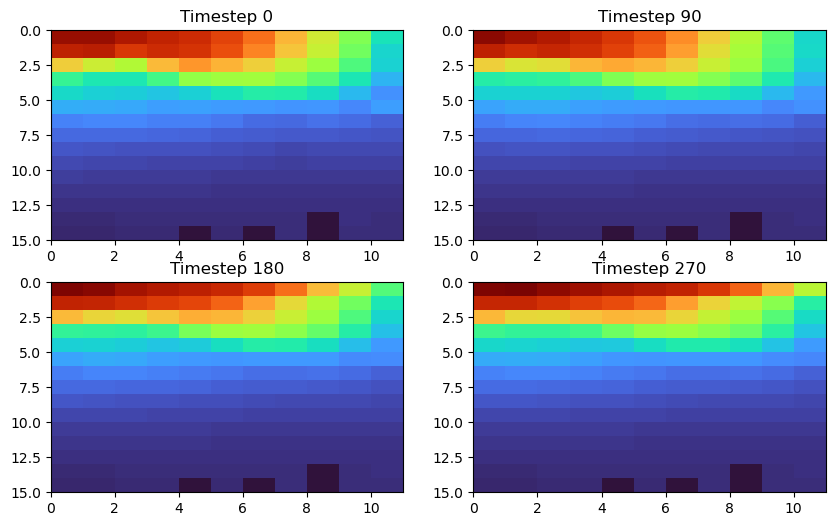

In [56]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.pcolormesh(theta_dv_east[0,:,:], cmap='turbo', vmin=0, vmax=29)
plt.gca().invert_yaxis()
plt.title('Timestep '+str(0))

plt.subplot(2,2,2)
plt.pcolormesh(theta_dv_east[90,:,:], cmap='turbo', vmin=0, vmax=29)
plt.gca().invert_yaxis()
plt.title('Timestep '+str(90))

plt.subplot(2,2,3)
plt.pcolormesh(theta_dv_east[180,:,:], cmap='turbo', vmin=0, vmax=29)
plt.gca().invert_yaxis()
plt.title('Timestep '+str(180))

plt.subplot(2,2,4)
plt.pcolormesh(theta_dv_east[270,:,:], cmap='turbo', vmin=0, vmax=29)
plt.gca().invert_yaxis()
plt.title('Timestep '+str(270))